# Spectral method for a  Hugget model with diffusive income and a life cycle

In [1]:
%run 'backend.ipynb'
backend_test_function()

<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


Backend import successful! - 2022-08-27 20:21:52.570166


# Economic parameters

In [2]:
# Interest rate
r = 0.04 # Average 30 year mortgage rate in 2019

In [3]:
# Utility
gamma = 2.
def u(x): return x**(1-gamma) / (1-gamma) # Utility function
def du(x): return x**(-gamma) # Marginal utility
def du_inv(x): return x**(-1/gamma) # Inverse marginal utility
rho = 0.05

In [4]:
# Exponential Ornstein-Uhlenbeck Income
zmedian = 70000 # Congressional Research Service, "The U.S. Income Distribution: Trends and Issues" (2021)
zmean = 100000 # Congressional Research Service, "The U.S. Income Distribution: Trends and Issues" (2021)
logincomegrowthp9010 = 0.8 # Bloom et al., "The Great Micro Moderation" (2017)

zcirc = zmedian
sig2 = (logincomegrowthp9010 / (2 * scipy.stats.norm.ppf(0.9)))**2
theta = sig2 / (4*np.log(zmean/zmedian))

print('Zcirc:', zcirc, 'Sig2:', sig2, 'Theta:', theta)

Zcirc: 70000 Sig2: 0.09741992966043918 Theta: 0.06828341275156506


In [5]:
# Assets
amin, amax = 0., 1000000. # 0 to +1M household wealth range

In [6]:
# Income
zmin, zmax = 30000., 500000. # 30k to 500k household income range

In [7]:
# Life-cycle
tmin, tmax = 25., 65.
altruism = 0.1 # Made up

In [8]:
# Age-income gradient
# From Guvenen et al., "Lifetime earnings in the united states over six decades" (2021)
# -> Cohort born in 1980 saw income increase between 25 and 55 of +37.04+22.12-1.29 = +57.87% ~ x1.6
psi = 1.6**(1/30) - 1
print(psi)

0.015790155174676634


# Numerical parameters

In [9]:
maxiter = 1000
crit = 1e-7

## Spectral parameters

In [10]:
N = 30 # Collocation points for a
a_sp, [Da, Daa] = dm.chebdif(N, 2)
a_sp, [Da, Daa] = rescale_nodes_and_derivatives(a_sp, [Da, Daa], left=amin, right=amax)

M = 20 # Collocation points for z
z_sp, [Dz, Dzz] = dm.chebdif(M, 2)
z_sp, [Dz, Dzz] = rescale_nodes_and_derivatives(z_sp, [Dz, Dzz], left=zmin, right=zmax)

O = 10 # Collocation points for t
t_sp, [Dt, Dtt] = dm.chebdif(O, 2)
t_sp, [Dt, Dtt] = rescale_nodes_and_derivatives(t_sp, [Dt, Dtt], left=tmin, right=tmax)

print(N, M, O, N*M*O)

30 20 10 6000


In [11]:
aidx_sp = pd.Index(a_sp, name='a')
zidx_sp = pd.Index(z_sp, name='z')
tidx_sp = pd.Index(t_sp, name='t')

In [12]:
# Offspring matrix
z_sp_offspring = zmin + (z_sp-zmin) / (1+psi)**(tmax-tmin)

weights = (-1.) ** np.arange(M)
weights[0], weights[-1] = weights[0]/2, weights[-1]/2
invdistances =  1 / (np.tile(z_sp_offspring, (M, 1)).T-np.tile(z_sp, (M, 1)))
invdistances[0,0] = 0.
os_sp = (np.diag(1/np.dot(invdistances,weights))@invdistances@np.diag(weights))
os_sp[0,0], os_sp[0,1:] = 1., 0.

/var/folders/0x/j6rztv6n3g75z6zj86jkb5t00000gp/T/ipykernel_6214/3799616795.py:6: RuntimeWarning: divide by zero encountered in divide
  invdistances =  1 / (np.tile(z_sp_offspring, (M, 1)).T-np.tile(z_sp, (M, 1)))


## Finite Volume Parameters

In [13]:
I = 80 # Collocation points for a
a_fv = np.linspace(amin,amax,I)
da_fv = a_fv[1]-a_fv[0]

J = 40 # Collocation points for z
z_fv = np.linspace(zmin,zmax,J)
dz_fv = z_fv[1]-z_fv[0]

K = int(tmax-tmin)+1 # Collocation points for t
t_fv = np.linspace(tmin,tmax,K)
dt_fv = t_fv[1]-t_fv[0]

print(I, J, K, I*J*K)

80 40 41 131200


In [14]:
aidx_fv = pd.Index(a_fv, name='a')
zidx_fv = pd.Index(z_fv, name='z')
tidx_fv = pd.Index(t_fv, name='t')

In [15]:
Da_fw = (1/da_fv)*(sparse.diags(np.ones(I-1), offsets=1)-sparse.diags(np.ones(I), offsets=0))
Da_fw[:,0] = -Da_fw[:,1]

Da_bw = (1/da_fv)*(sparse.diags(np.ones(I), offsets=0)-sparse.diags(np.ones(I-1), offsets=-1))
Da_bw[:,-1] = -Da_bw[:,-2]


Dz_fw = (1/dz_fv)*(sparse.diags(np.ones(J-1), offsets=1)-sparse.diags(np.ones(J), offsets=0))
Dz_fw[:,0] = -Dz_fw[:,1]

Dz_bw = (1/dz_fv)*(sparse.diags(np.ones(J), offsets=0)-sparse.diags(np.ones(J-1), offsets=-1))
Dz_bw[:,-1] = -Dz_bw[:,-2]

Dzz_cent = (1/dz_fv**2)*(sparse.diags(np.ones(J-1), offsets=1)-2*sparse.diags(np.ones(J), offsets=0)+sparse.diags(np.ones(J-1), offsets=-1))
Dzz_cent[1,0], Dzz_cent[-2,-1] = -Dzz_cent[0,0], -Dzz_cent[-1,-1]


Dt_bw = (1/dt_fv)*(sparse.diags(np.ones(K), offsets=0)-sparse.diags(np.ones(K-1), offsets=-1))
Dt_bw[0,-1] = -Dt_bw[-1,-1]

/Users/constantinschesch/opt/anaconda3/lib/python3.9/site-packages/scipy/sparse/_index.py:137: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray_sparse(i, j, x)
/Users/constantinschesch/opt/anaconda3/lib/python3.9/site-packages/scipy/sparse/_index.py:103: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


In [16]:
# Offspring matrix
z_fv_offspring = zmin + (z_fv-zmin) / (1+psi)**(tmax-tmin)
z_fv_offspring_idxs = np.abs(z_fv-z_fv_offspring.reshape(-1, 1)).argmin(axis=1)

os_fv = sparse.csc_matrix((J,J))
os_fv[np.arange(J), z_fv_offspring_idxs] = 1.

/Users/constantinschesch/opt/anaconda3/lib/python3.9/site-packages/scipy/sparse/_index.py:146: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


## Offspring matrix plot

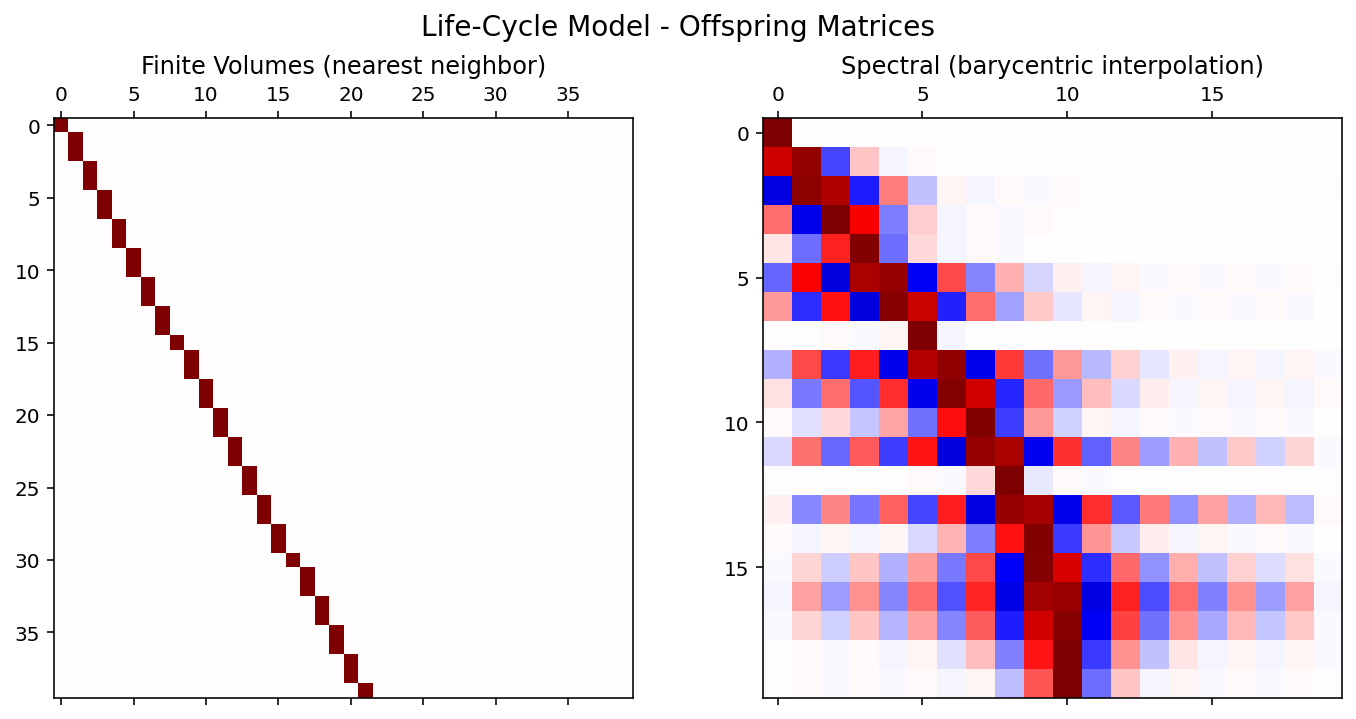

Saved to: life_cycle_offspring_matrix_plot.pdf


In [17]:
plotmats([os_fv.todense(), os_sp], ['Finite Volumes (nearest neighbor)', 'Spectral (barycentric interpolation)'], shape=(1,2), figsize=(10,5), 
         suptitle='Life-Cycle Model - Offspring Matrices', filename='life_cycle_offspring_matrix_plot')

# Income and wealth

## Hamilton-Jacobi-Bellman Equation

In [18]:
midx_sp = pd.MultiIndex.from_product([aidx_sp, zidx_sp])

aa_sp = midx_sp.get_level_values('a').values
zz_sp = midx_sp.get_level_values('z').values

mumu_sp = (theta*(np.log(zcirc) - np.log(zz_sp)) + sig2/2)*zz_sp
sig2sig2_sp = sig2*zz_sp**2

D_a = kronecker_broadcast_along_index_level(Da, midx_sp, 'a')
D_z = kronecker_broadcast_along_index_level(Dz, midx_sp, 'z')
D_zz = kronecker_broadcast_along_index_level(Dzz, midx_sp, 'z')

aminidx = int_index_from_labels(midx_sp, a_sp[0])
amaxidx = int_index_from_labels(midx_sp, a_sp[-1])

bc1idx = int_index_from_labels(midx_sp, (slice(None),[z_sp[0], z_sp[-1]]))

v0 = u(zz_sp + r*aa_sp)/rho

In [19]:
%%time

v = v0.copy()

for i in range(maxiter):
    
    delta = 0.001*(i+1)**3
        
    dv = D_a@v
    c = du_inv(dv)
    s = zz_sp + r*aa_sp - c
    
    A = s.reshape(-1,1)*D_a + mumu_sp.reshape(-1,1)*D_z + (sig2sig2_sp/2).reshape(-1,1)*D_zz
    B = np.eye(N*M)*(1/delta + rho) - A
    b = u(c) + v/delta

    B[bc1idx] = D_z[bc1idx]
    b[bc1idx] = 0

    v_next = np.linalg.solve(B, b)
    s_next = zz_sp + r*aa_sp - du_inv(D_a@v_next)

    bc2idx_amin = aminidx[s_next[aminidx]<0]
    bc2idx_amax = amaxidx[s_next[amaxidx]>0]
    bc2idx = np.union1d(bc2idx_amin, bc2idx_amax)

    B[bc2idx] = D_a[bc2idx]
    b[bc2idx] = du(zz_sp + r*aa_sp)[bc2idx]
    
    v_old, s = v.copy(), s.copy()
    v = np.linalg.solve(B, b)
        
    dist = np.max(np.abs(v - v_old))
    if dist < crit:
        print('Finished! - Loops:', i+1, ' - Last distance:', dist, ' - Last delta:', delta)
        break
    elif i == maxiter - 1 : print('Failed to converge! - Loops:', i+1, ' - Last distance:', dist, ' - Last delta:', delta)

Finished! - Loops: 27  - Last distance: 8.678517922914219e-08  - Last delta: 19.683
CPU times: user 716 ms, sys: 77.5 ms, total: 793 ms
Wall time: 506 ms


# Income, wealth and life-cycle

## Hamilton-Jacobi-Bellman Equation

In [20]:
midx_lc = pd.MultiIndex.from_product([tidx_sp, aidx_sp, zidx_sp])

ttt_sp = midx_lc.get_level_values('t').values
aaa_sp = midx_lc.get_level_values('a').values
zzz_sp = midx_lc.get_level_values('z').values

zcirczcirczcirc_sp = zcirc*(1+psi)**(ttt_sp-(tmax+tmin)/2)
mumumu_sp = (theta*(np.log(zcirczcirczcirc_sp) - np.log(zzz_sp)) + sig2/2)*zzz_sp + psi*zzz_sp #CCC
sig2sig2sig2_lc = sig2*zzz_sp**2

D__a = kronecker_broadcast_along_index_level(Da, midx_lc, 'a')
D__z = kronecker_broadcast_along_index_level(Dz, midx_lc, 'z')
D__zz = kronecker_broadcast_along_index_level(Dzz, midx_lc, 'z')
D__t = kronecker_broadcast_along_index_level(Dt, midx_lc, 't')
OS__t = kronecker_broadcast_along_index_level(os_sp, midx_lc, 'z')

In [21]:
tminidx_lc = int_index_from_labels(midx_lc, t_sp[0])
tminidx_lc_ = list_of_lists_from_int_idx(tminidx_lc)
tmaxidx_lc = int_index_from_labels(midx_lc, t_sp[-1])
tmaxidx_lc_ = list_of_lists_from_int_idx(tmaxidx_lc)

aminidx_lc = int_index_from_labels(midx_lc, (slice(None), a_sp[0]))
amaxidx_lc = int_index_from_labels(midx_lc, (slice(None), a_sp[-1]))

bc1idx = int_index_from_labels(midx_lc, (slice(None),slice(None),[z_sp[0],z_sp[-1]]))

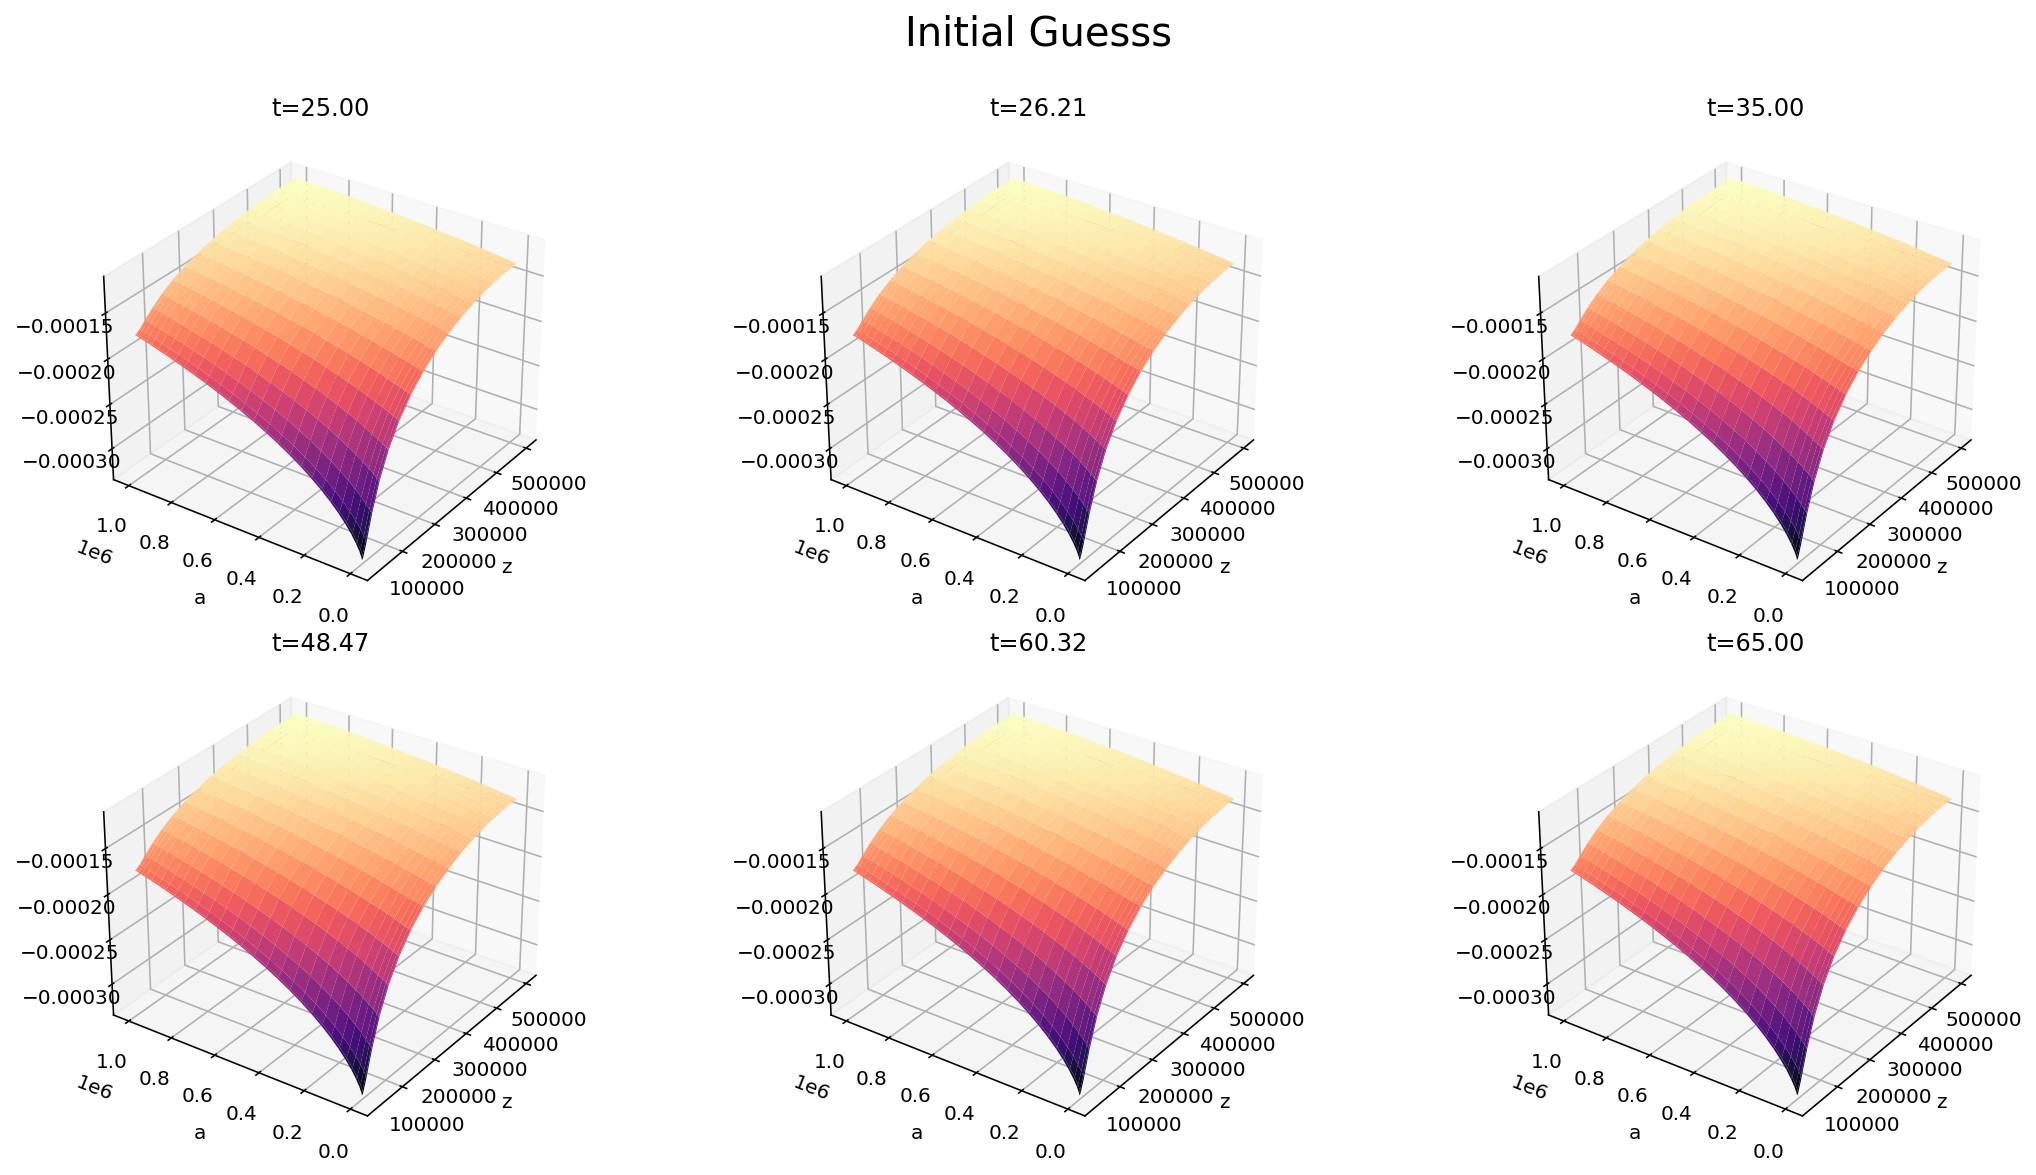

Saved to: life_cycle_value_spectral.pdf


In [22]:
v0_lc = np.tile(v, O)

plot_3D_surface_split(t_sp, a_sp, z_sp, v0_lc, zlabel='t', xlabel='z', ylabel='a', suptitle='Initial Guesss', filename='life_cycle_value_spectral')

In [23]:
%%time

v_lc = v0_lc.copy()

for i in trange(maxiter):
    
    delta = 0.0001*(i+1)**2
    
    dv = D__a@v_lc
    c = du_inv(dv)
    s = zzz_sp + r*aaa_sp - c
    
    A = s.reshape(-1,1)*D__a + mumumu_sp.reshape(-1,1)*D__z + (sig2sig2sig2_lc/2).reshape(-1,1)*D__zz + D__t
    B = np.eye(N*M*O)*(1/delta + rho) - A
    b = u(c) + v_lc/delta
    
    # Boundary condition 1
    B[bc1idx] = D__z[bc1idx]
    b[bc1idx] = 0
    
    # Boundary condition 2
    v_lc_next = np.linalg.solve(B, b)
    dv_next = D__a@v_lc_next
    s_next = zzz_sp + r*aaa_sp - du_inv(dv_next)

    bc2idx_amin = aminidx_lc[s_next[aminidx_lc]<0]
    bc2idx_amax = amaxidx_lc[s_next[amaxidx_lc]>0]
    bc2idx = np.union1d(bc2idx_amin, bc2idx_amax)

    B[bc2idx] = D__a[bc2idx]
    b[bc2idx] = du(zzz_sp + r*aaa_sp)[bc2idx]

    # Boundary condition 3: v(a, z, tmax) = 0
    B[tmaxidx_lc] = np.eye(N*M*O)[tmaxidx_lc]
    b[tmaxidx_lc] = altruism*(OS__t@v_lc)[tminidx_lc]

    v_lc_old, s_lc = v_lc.copy(), s.copy()
    v_lc = np.linalg.solve(B, b)
    
    dist = np.max(np.abs(v_lc - v_lc_old))
    if dist < crit and i>=5:
        print('Finished! - Loops:', i+1, ' - Last distance:', dist, ' - Last delta:', delta)
        break
    elif i == maxiter - 1 : print('Failed to converge! - Loops:', i+1, ' - Last distance:', dist, ' - Last delta:', delta)
    else: print('Loop:', i+1, ' - Last distance:', dist, ' - Last delta:', delta)

  0%|          | 0/1000 [00:00<?, ?it/s]

Loop: 1  - Last distance: 0.0002978210101024078  - Last delta: 0.0001
Loop: 2  - Last distance: 4.938620461983779e-08  - Last delta: 0.0004
Loop: 3  - Last distance: 1.1108083632706571e-07  - Last delta: 0.0009000000000000001
Loop: 4  - Last distance: 1.974162854892188e-07  - Last delta: 0.0016
Loop: 5  - Last distance: 3.0832854205160767e-07  - Last delta: 0.0025
Loop: 6  - Last distance: 4.437078120571032e-07  - Last delta: 0.0036000000000000003
Loop: 7  - Last distance: 6.034045702413564e-07  - Last delta: 0.0049
Loop: 8  - Last distance: 7.87210665328475e-07  - Last delta: 0.0064
Loop: 9  - Last distance: 9.94849244669038e-07  - Last delta: 0.0081
Loop: 10  - Last distance: 1.2259636488122657e-06  - Last delta: 0.01
Loop: 11  - Last distance: 1.480104099900513e-06  - Last delta: 0.012100000000000001
Loop: 12  - Last distance: 1.7567174936198573e-06  - Last delta: 0.014400000000000001
Loop: 13  - Last distance: 2.055128338707818e-06  - Last delta: 0.016900000000000002
Loop: 14  - La

/var/folders/0x/j6rztv6n3g75z6zj86jkb5t00000gp/T/ipykernel_6214/3810454397.py:5: RuntimeWarning: invalid value encountered in power
  def du_inv(x): return x**(-1/gamma) # Inverse marginal utility


Loop: 31  - Last distance: 9.221799377918282e-06  - Last delta: 0.0961
Loop: 32  - Last distance: 9.526663323149626e-06  - Last delta: 0.1024
Loop: 33  - Last distance: 9.791659789866962e-06  - Last delta: 0.10890000000000001
Loop: 34  - Last distance: 1.0010989982044388e-05  - Last delta: 0.11560000000000001
Loop: 35  - Last distance: 1.0179041102937269e-05  - Last delta: 0.12250000000000001
Loop: 36  - Last distance: 1.0290284688625252e-05  - Last delta: 0.1296
Loop: 37  - Last distance: 1.033940357338719e-05  - Last delta: 0.1369
Loop: 38  - Last distance: 1.0321417816840599e-05  - Last delta: 0.1444
Loop: 39  - Last distance: 1.023185909204325e-05  - Last delta: 0.1521
Loop: 40  - Last distance: 1.0066957567949855e-05  - Last delta: 0.16
Loop: 41  - Last distance: 9.82380340486422e-06  - Last delta: 0.1681
Loop: 42  - Last distance: 9.500537771189247e-06  - Last delta: 0.1764
Loop: 43  - Last distance: 9.096647333053069e-06  - Last delta: 0.1849
Loop: 44  - Last distance: 8.6126526

In [24]:
c_lc = du_inv(D__a@v_lc)
s_lc = zzz_sp + r*aaa_sp - c_lc

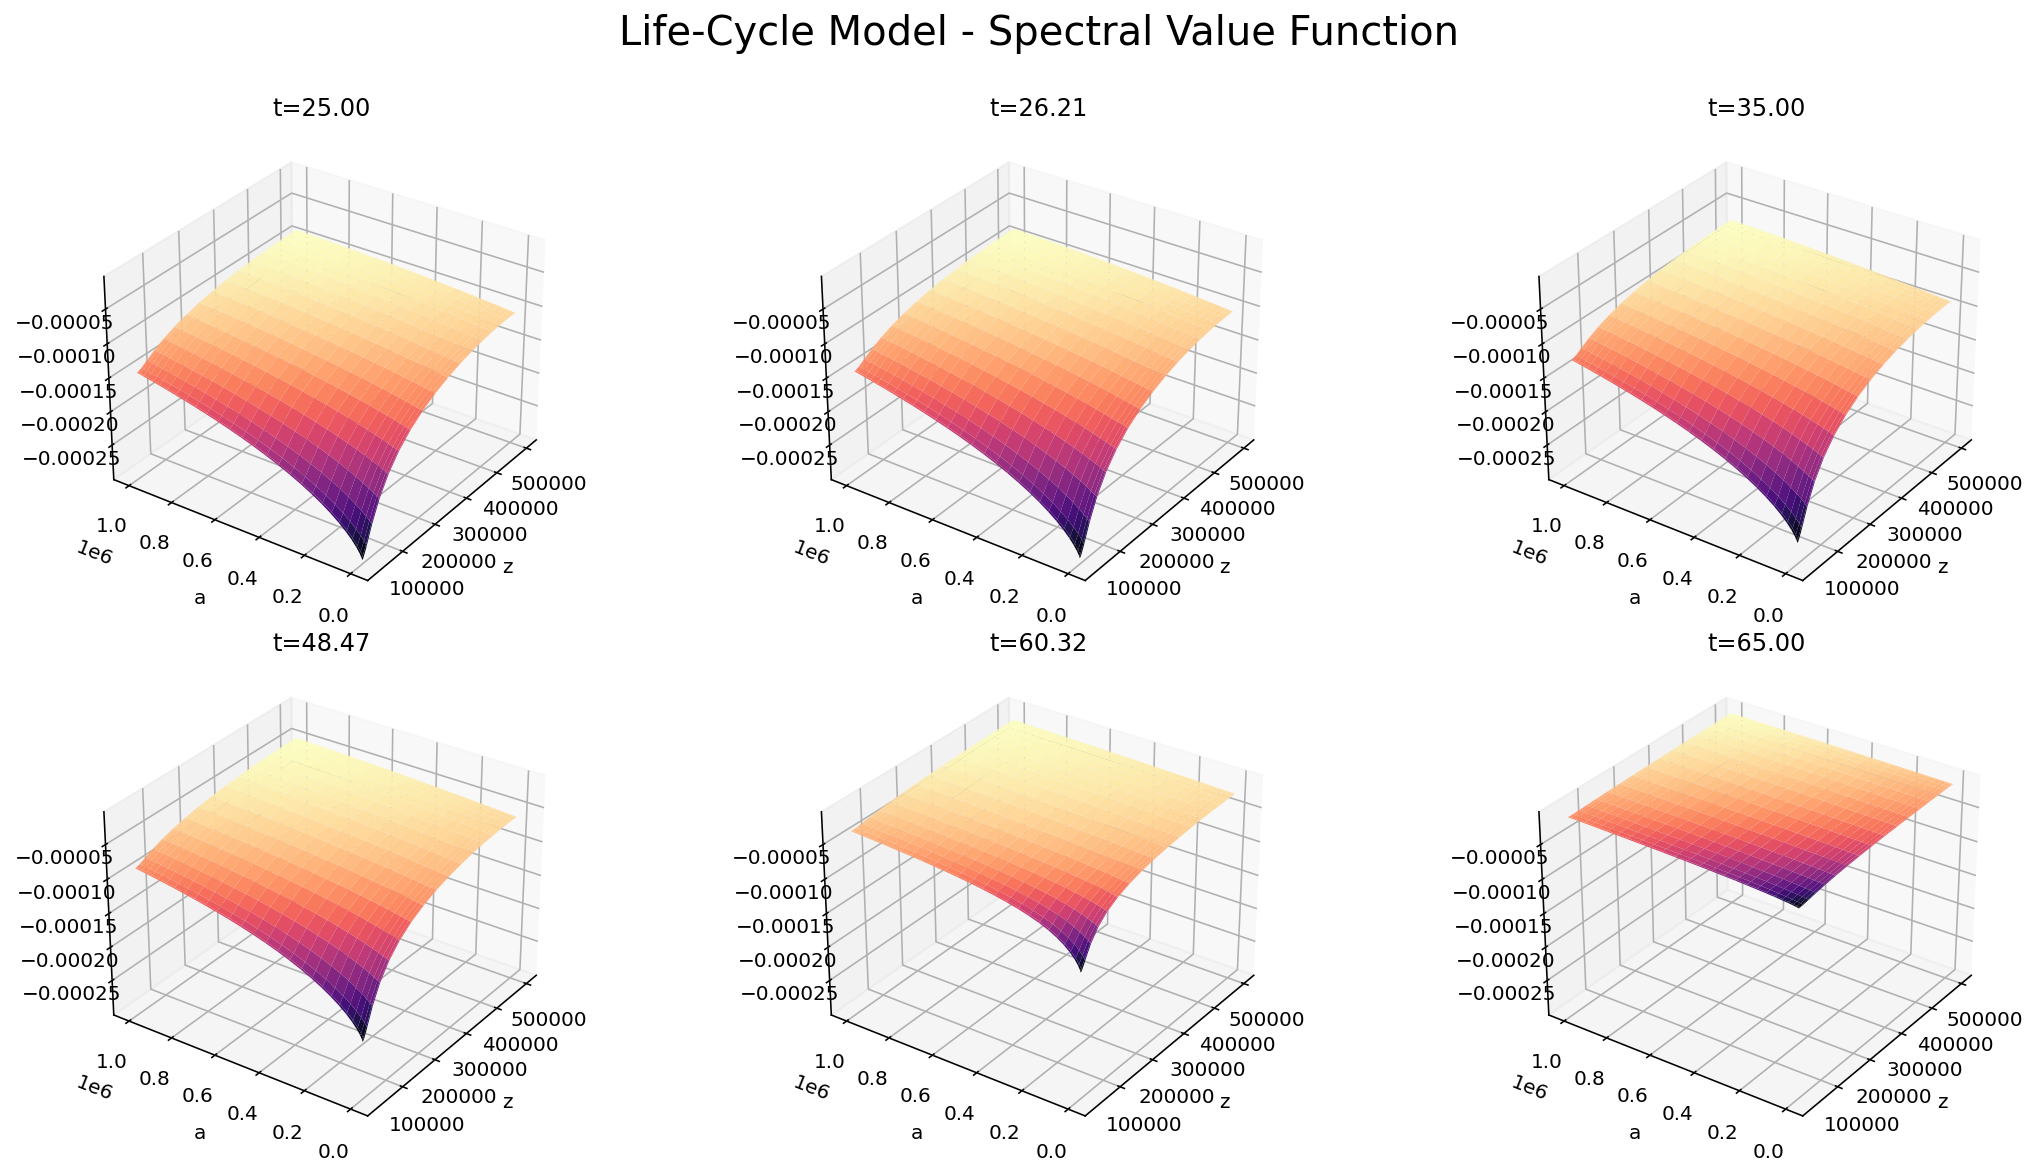

Saved to: life_cycle_value.pdf


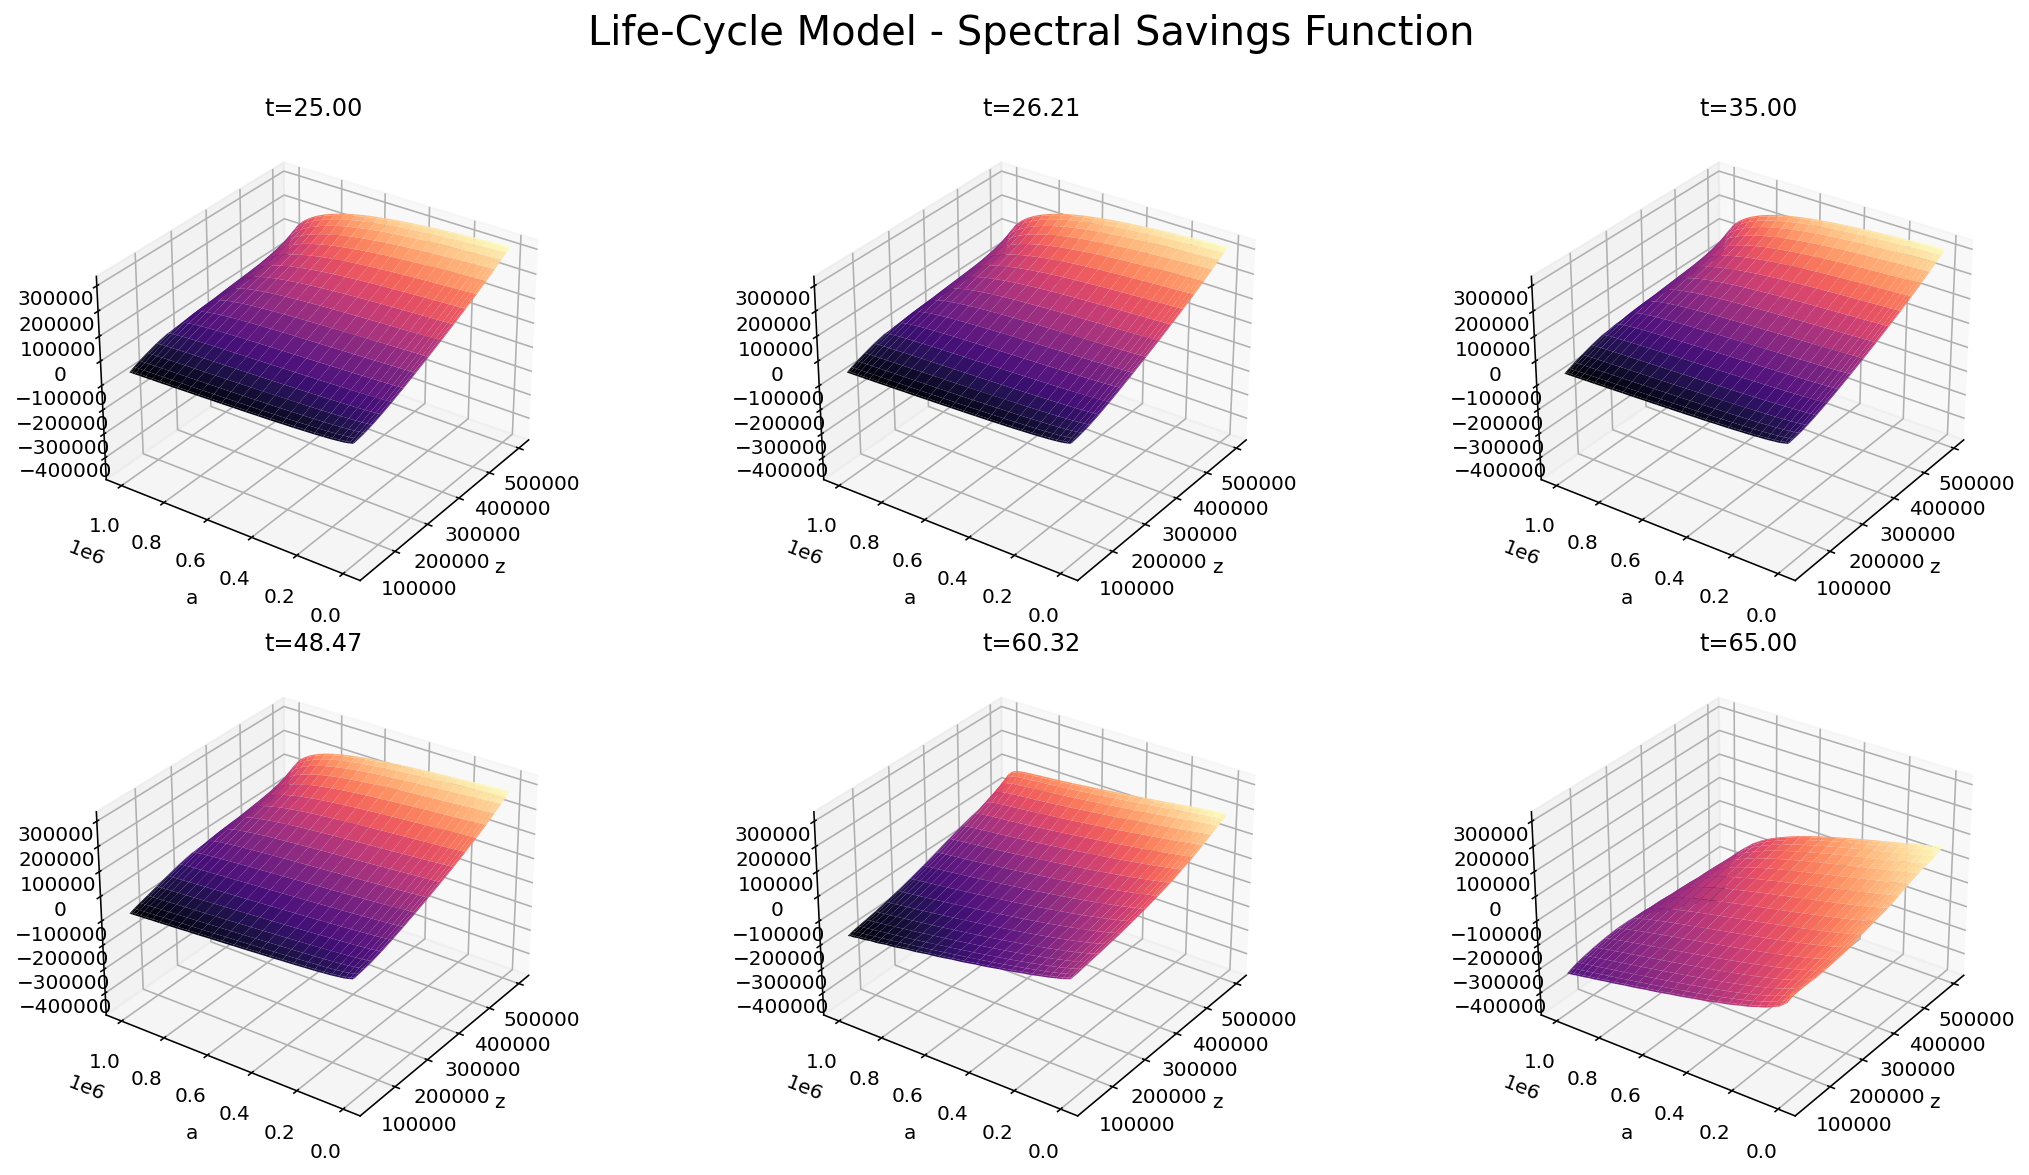

Saved to: life_cycle_savings.pdf


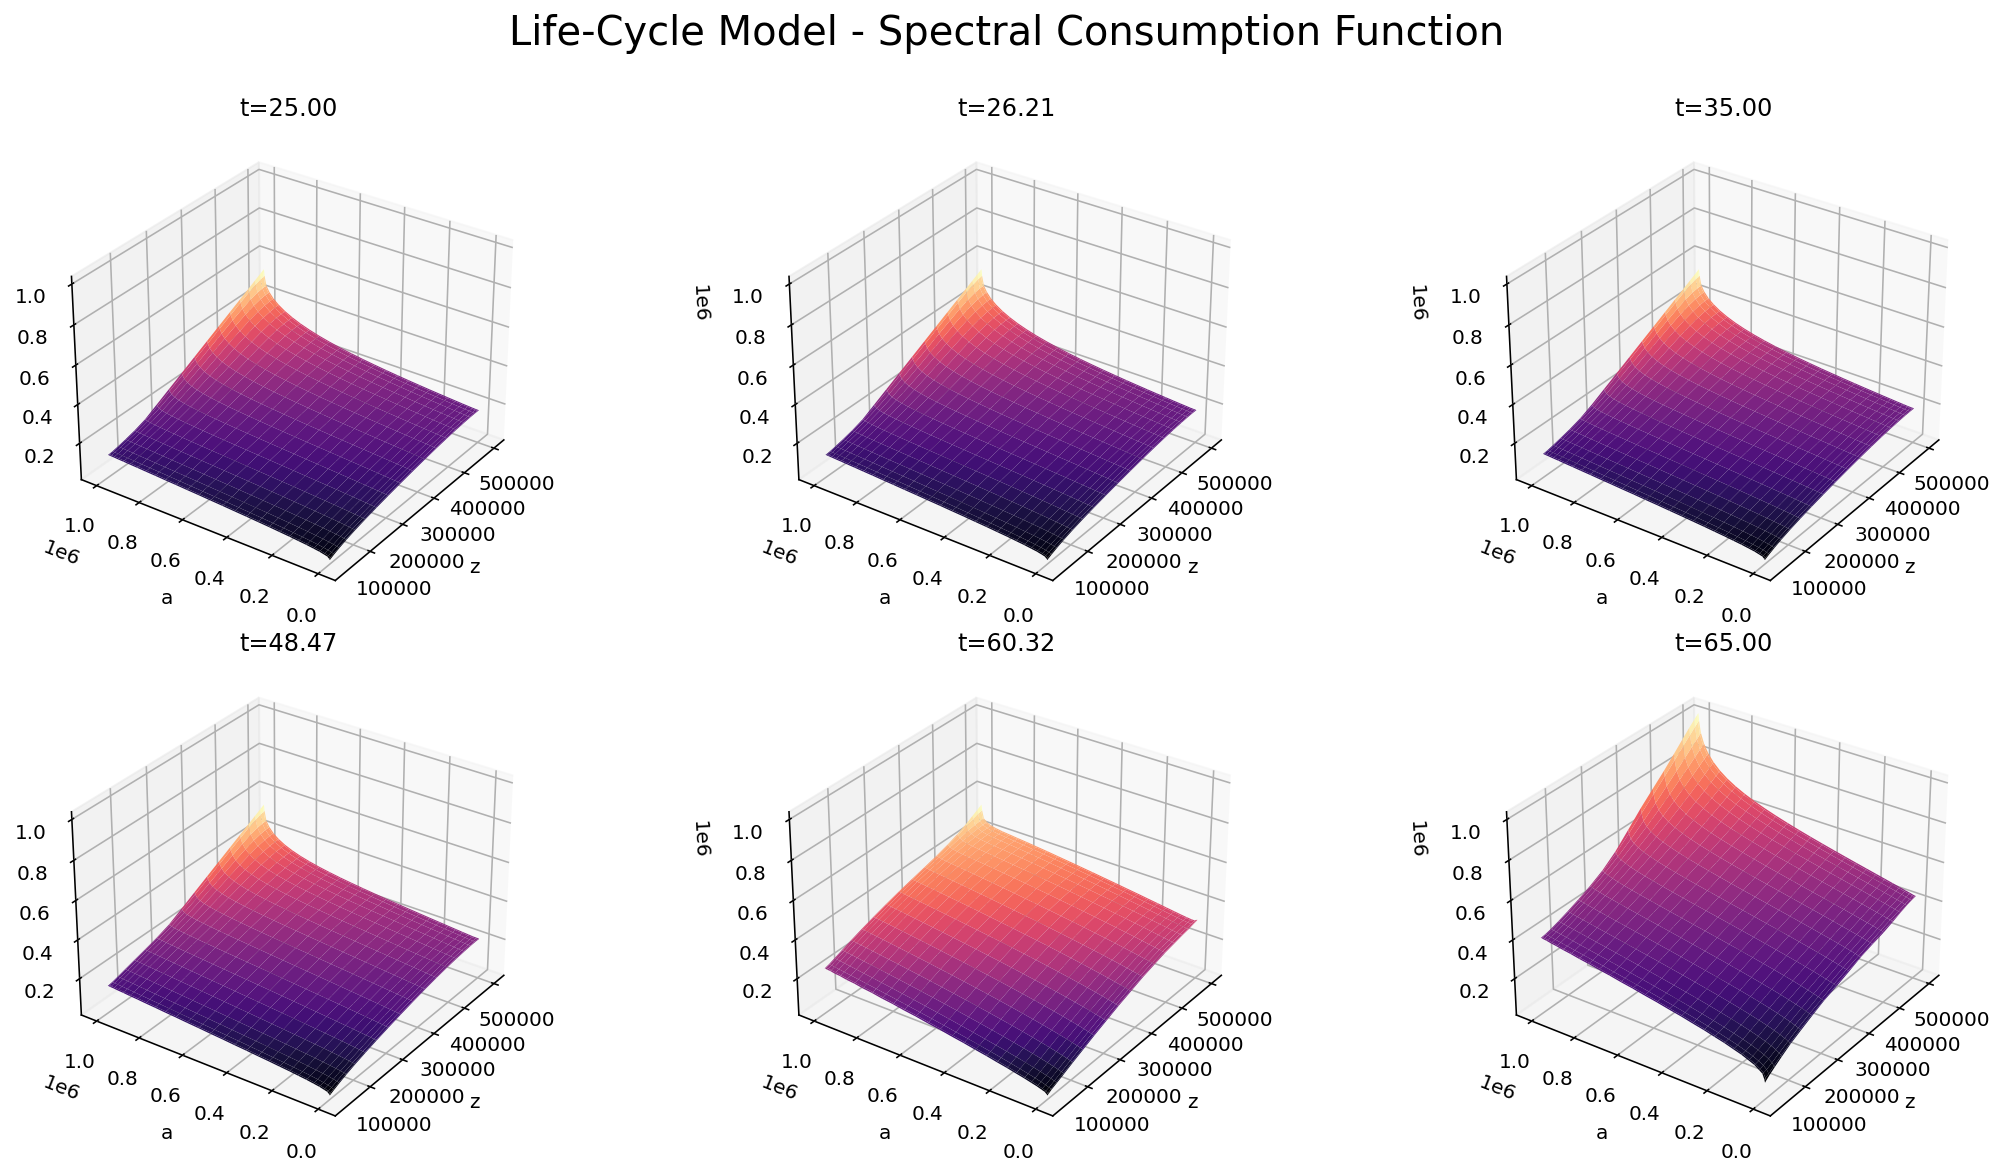

Saved to: life_cycle_consumption.pdf


In [25]:
plot_3D_surface_split(t_sp, a_sp, z_sp, v_lc, zlabel='t', xlabel='z', ylabel='a', suptitle='Life-Cycle Model - Spectral Value Function', filename='life_cycle_value')
plot_3D_surface_split(t_sp, a_sp, z_sp, s_lc, zlabel='t', xlabel='z', ylabel='a', suptitle='Life-Cycle Model - Spectral Savings Function', filename='life_cycle_savings')
plot_3D_surface_split(t_sp, a_sp, z_sp, c_lc, zlabel='t', xlabel='z', ylabel='a', suptitle='Life-Cycle Model - Spectral Consumption Function', filename='life_cycle_consumption')

In [26]:
v_lc_interp = timespline(t_sp, a_sp, z_sp, v_lc, t_fv, a_fv, z_fv)
s_lc_interp = timespline(t_sp, a_sp, z_sp, s_lc, t_fv, a_fv, z_fv)
c_lc_interp = timespline(t_sp, a_sp, z_sp, c_lc, t_fv, a_fv, z_fv)

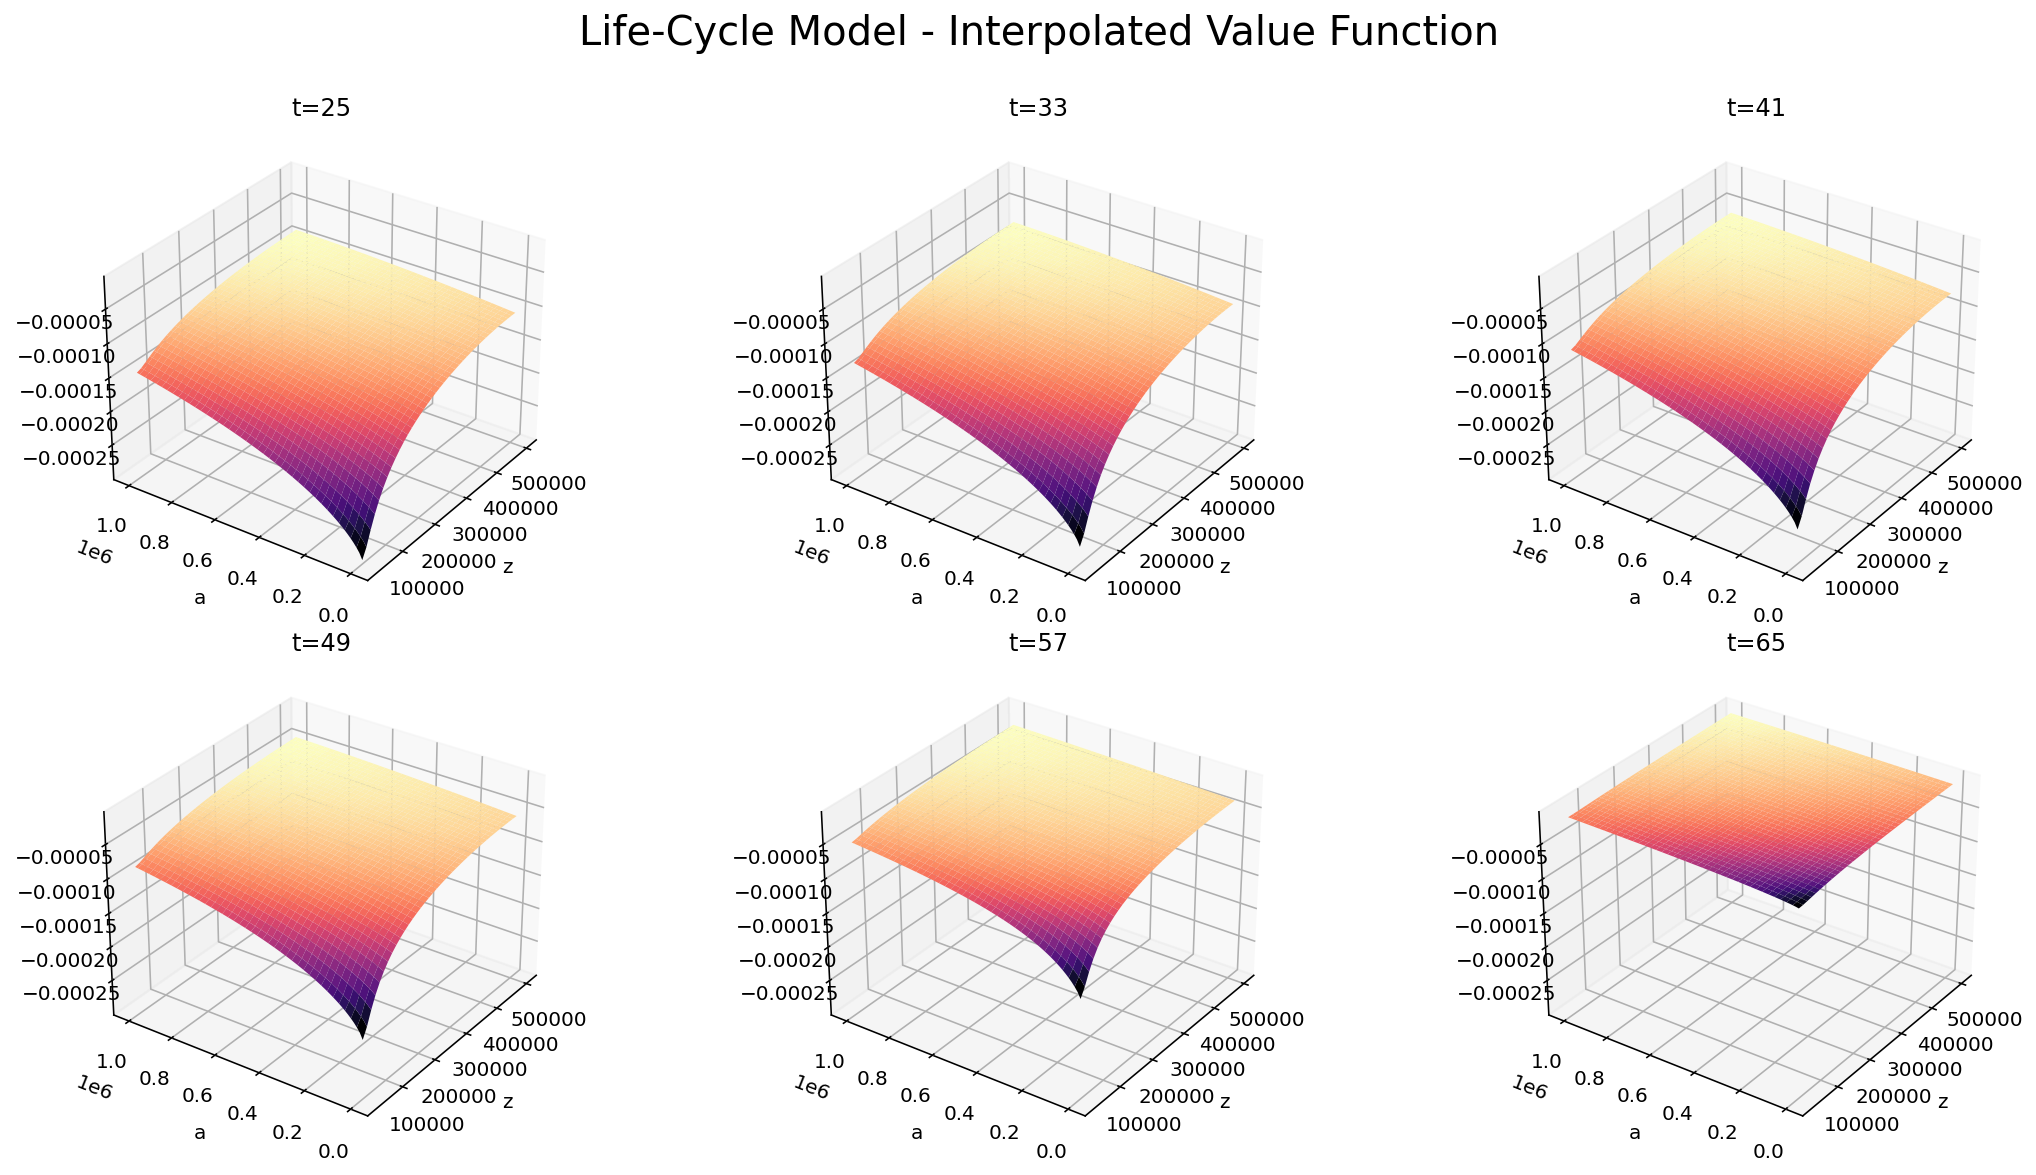

Saved to: life_cycle_value_interpolated.pdf


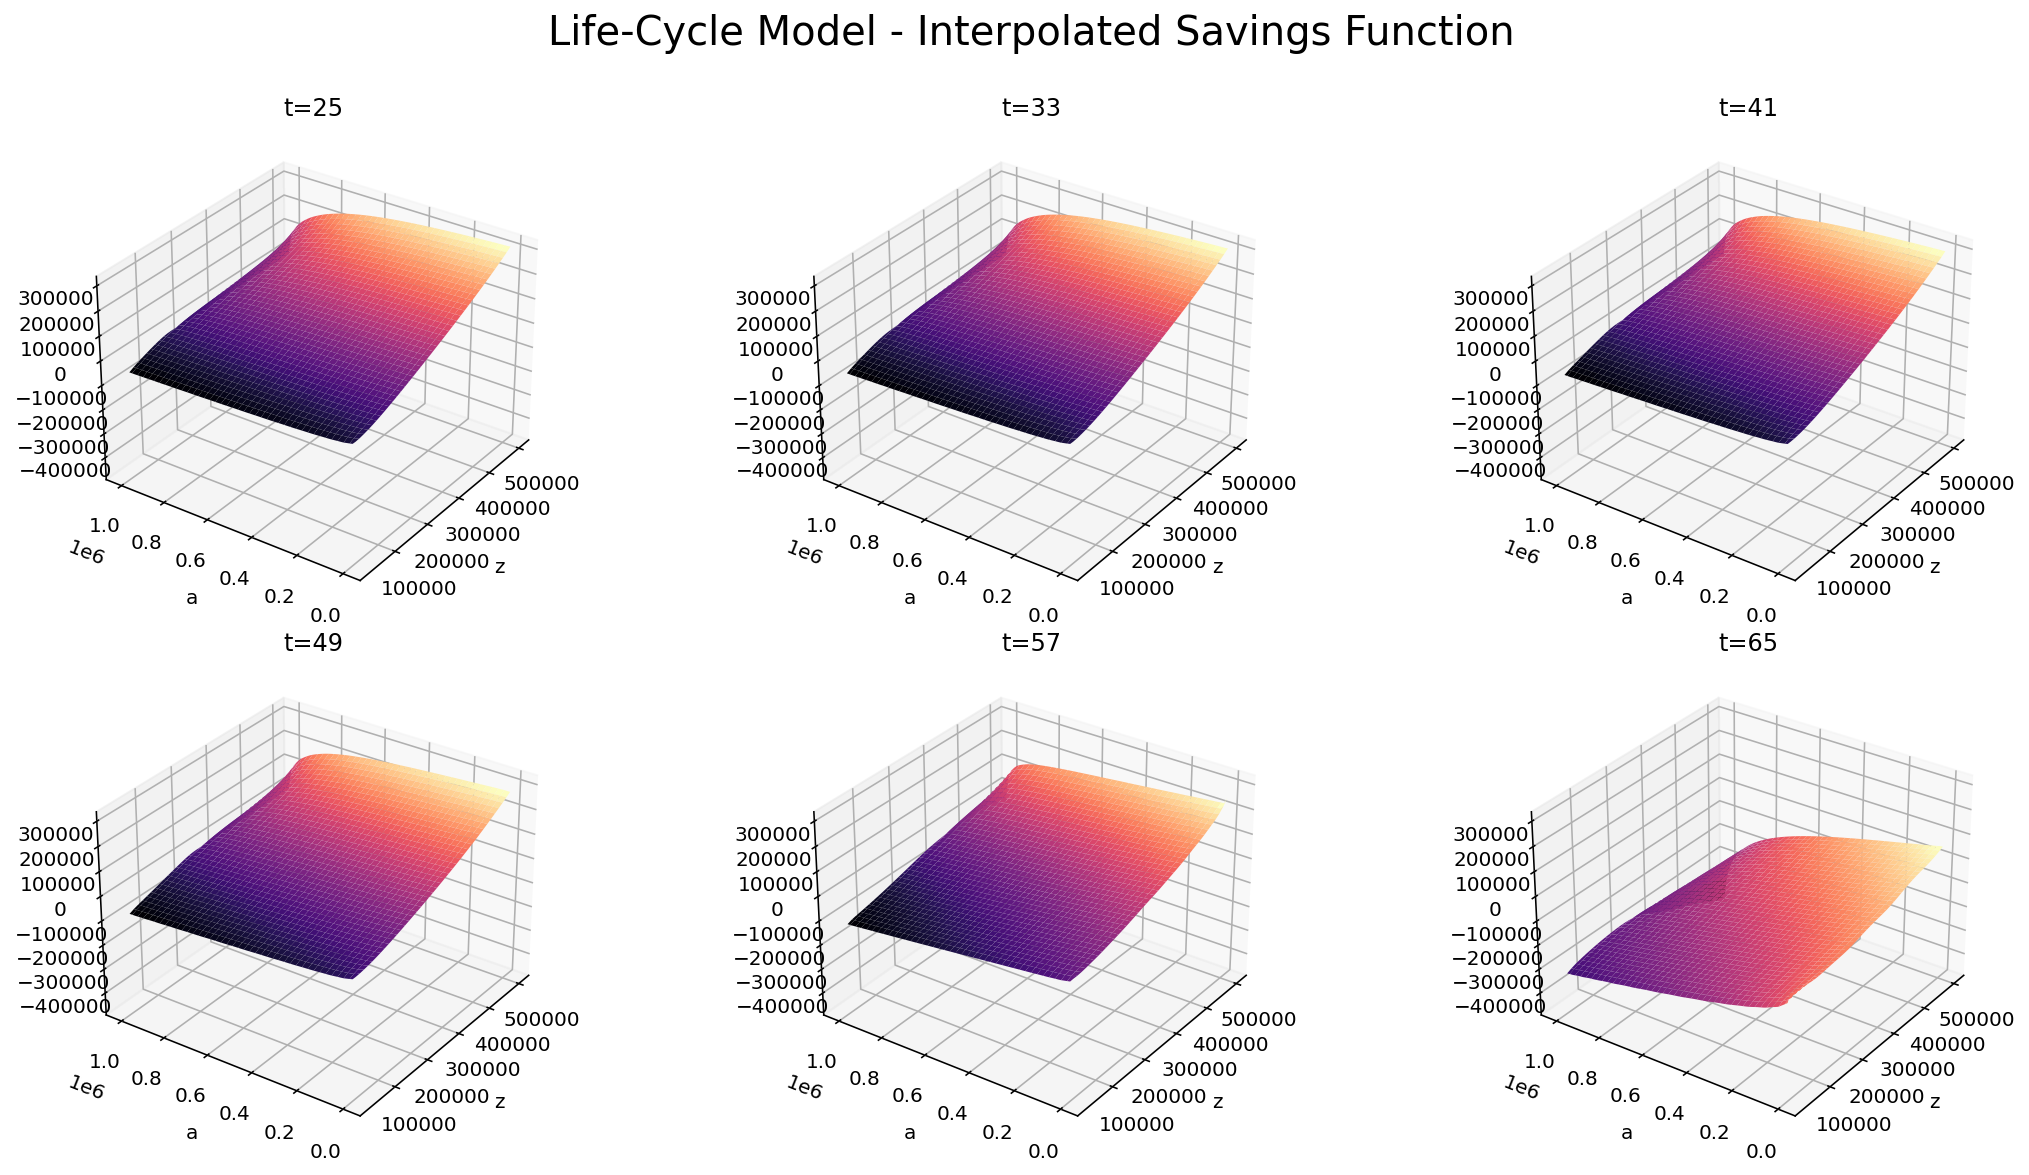

Saved to: life_cycle_savings_interpolated.pdf


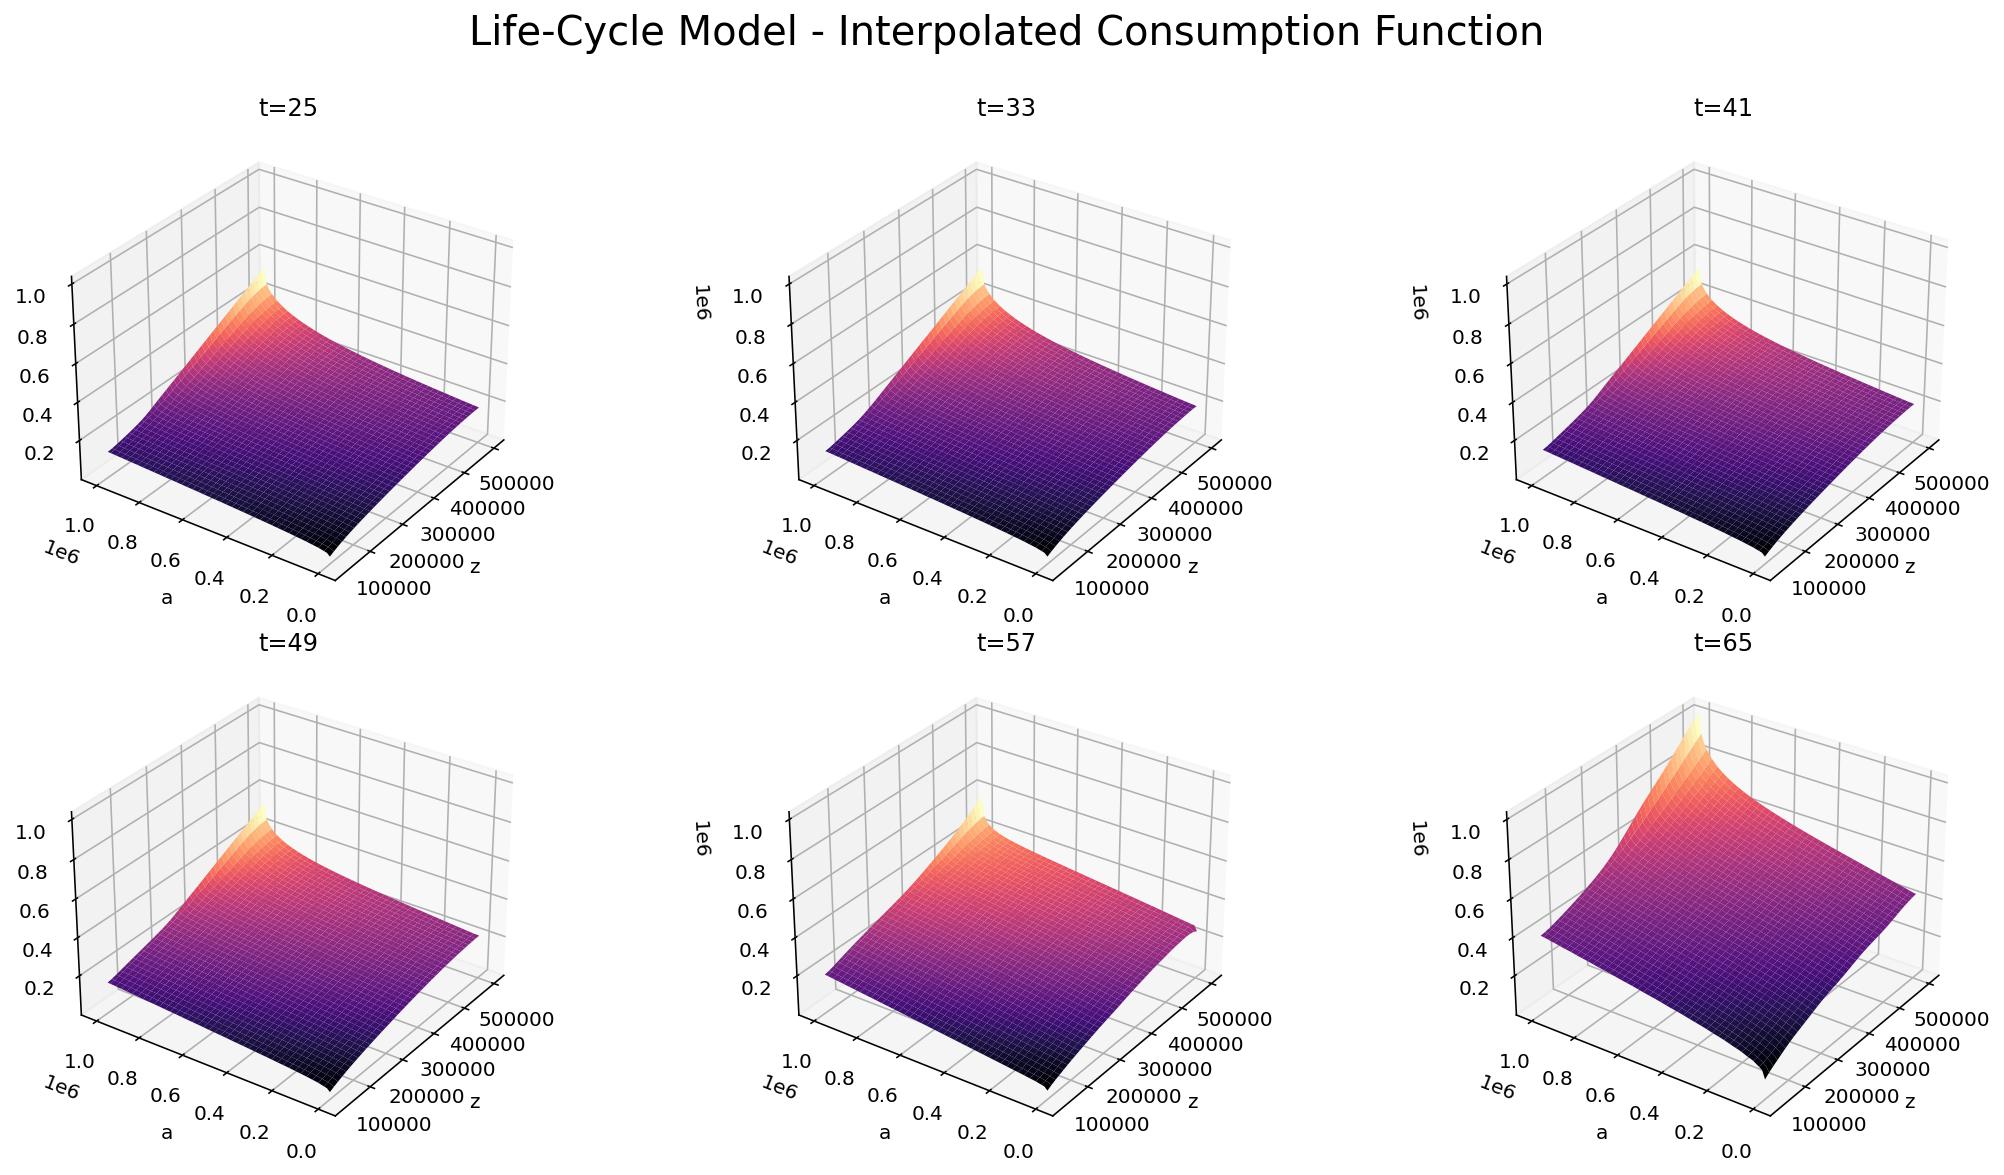

Saved to: life_cycle_consumption_interpolated.pdf


In [27]:
plot_3D_surface_split(t_fv, a_fv, z_fv, v_lc_interp, zlabel='t', xlabel='z', ylabel='a', suptitle='Life-Cycle Model - Interpolated Value Function', filename='life_cycle_value_interpolated')
plot_3D_surface_split(t_fv, a_fv, z_fv, s_lc_interp, zlabel='t', xlabel='z', ylabel='a', suptitle='Life-Cycle Model - Interpolated Savings Function', filename='life_cycle_savings_interpolated')
plot_3D_surface_split(t_fv, a_fv, z_fv, c_lc_interp, zlabel='t', xlabel='z', ylabel='a', suptitle='Life-Cycle Model - Interpolated Consumption Function', filename='life_cycle_consumption_interpolated')

## Kolmogorov Forward Equation

In [28]:
midx_fv = pd.MultiIndex.from_product([tidx_fv, aidx_fv, zidx_fv])
ttt_fv = midx_fv.get_level_values('t').values
aaa_fv = midx_fv.get_level_values('a').values
zzz_fv = midx_fv.get_level_values('z').values

zcirczcirczcirc_fv = zcirc*(1+psi)**(ttt_fv-(tmax+tmin)/2)
mumumu_fv = (theta*(np.log(zcirczcirczcirc_fv) - np.log(zzz_fv)) + sig2/2)*zzz_fv + psi*zzz_fv
sig2sig2sig2_fv = sig2*zzz_fv**2

In [29]:
D_a_fw = kronecker_broadcast_along_index_level(Da_fw, midx_fv, 'a')
D_a_bw = kronecker_broadcast_along_index_level(Da_bw, midx_fv, 'a')

D_z_fw = kronecker_broadcast_along_index_level(Dz_fw, midx_fv, 'z')
D_z_bw = kronecker_broadcast_along_index_level(Dz_bw, midx_fv, 'z')
D_zz_cent = kronecker_broadcast_along_index_level(Dzz_cent, midx_fv, 'z')

D_t_bw = kronecker_broadcast_along_index_level(Dt_bw, midx_fv, 't')

In [30]:
C_income_wealth_lifecycle_savings_drift = - (D_a_bw*sparse.diags(np.maximum(s_lc_interp,0))+D_a_fw*sparse.diags(np.minimum(s_lc_interp,0)))
C_income_wealth_lifecycle_income_drift = - (D_z_bw*sparse.diags(np.maximum(mumumu_fv,0))+D_z_fw*sparse.diags(np.minimum(mumumu_fv,0)))
C_income_wealth_lifecycle_income_diffusion = D_zz_cent*sparse.diags(sig2sig2sig2_fv/2)

In [31]:
tmaxidx = int_index_from_labels(midx_fv, tmax)
tminidx = int_index_from_labels(midx_fv, tmin)
tminidx_ = list_of_lists_from_int_idx(tminidx)

C_income_wealth_lifecycle_time_drift = -D_t_bw
C_income_wealth_lifecycle_time_drift = C_income_wealth_lifecycle_time_drift.tolil()
C_income_wealth_lifecycle_time_drift[tminidx] = 0.
C_income_wealth_lifecycle_time_drift[tminidx_,tminidx] = -(1/dt_fv)*sparse.eye(I*J)
C_income_wealth_lifecycle_time_drift[tminidx_,tmaxidx] = (1/dt_fv)*sparse.kron(sparse.eye(I),os_fv.T).tocsc()
C_income_wealth_lifecycle_time_drift = C_income_wealth_lifecycle_time_drift.tocsc()

test_transpose_generator(C_income_wealth_lifecycle_time_drift)

Diagonal -> Min: -1.0  Mean: -1.0  Max: -1.0
Off-diagonal -> Min: 0.0  Mean: 7.621951219512195e-06  Max: 1.0
Maximum absolute off-diagonal vs diagonal error: 0.0


In [32]:
C_income_wealth_lifecycle = C_income_wealth_lifecycle_savings_drift + C_income_wealth_lifecycle_income_drift + C_income_wealth_lifecycle_income_diffusion + C_income_wealth_lifecycle_time_drift

test_transpose_generator(C_income_wealth_lifecycle)

Diagonal -> Min: -208.3340817630816  Mean: -69.59096090844196  Max: -1.8550318256741236
Off-diagonal -> Min: 0.0  Mean: 0.0005304189093631247  Max: 171.47715451823768
Maximum absolute off-diagonal vs diagonal error: 3.019806626980426e-14


In [33]:
%%time
l, g_income_wealth_lifecycle = sparse.linalg.eigs(C_income_wealth_lifecycle, sigma=0, k=1)
l, g_income_wealth_lifecycle = np.real(l).squeeze(), np.real(g_income_wealth_lifecycle).flatten()
print('l:', l)
g_income_wealth_lifecycle = g_income_wealth_lifecycle / (g_income_wealth_lifecycle[tmaxidx].sum()*da_fv*dz_fv)

l: -1.368114043227032e-16
CPU times: user 2min 56s, sys: 19.8 s, total: 3min 16s
Wall time: 2min 8s


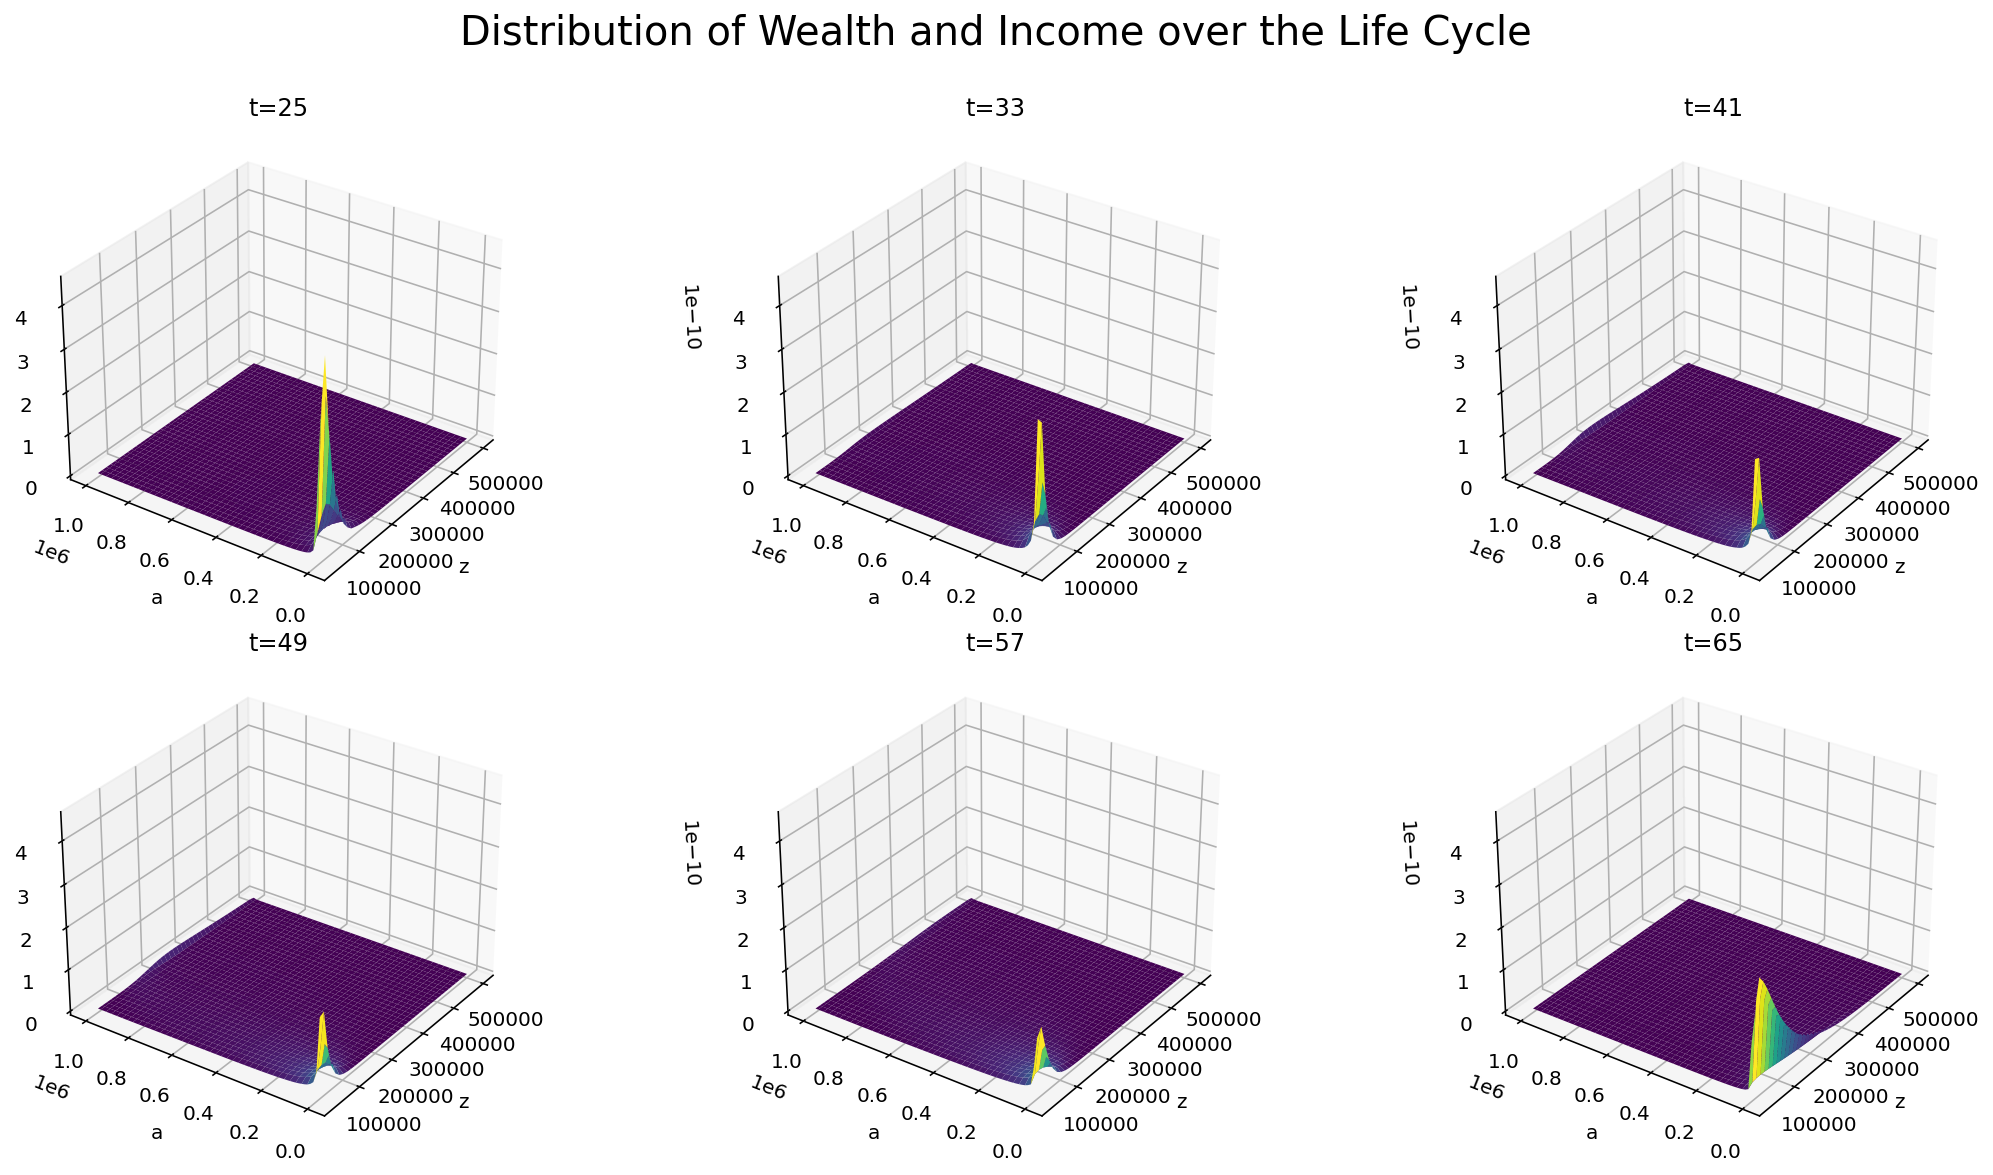

Saved to: life_cycle_distribution.pdf


In [34]:
plot_3D_surface_split(t_fv, a_fv, z_fv, g_income_wealth_lifecycle, zlabel='t', xlabel='z', ylabel='a', cmap=cm.viridis, suptitle='Distribution of Wealth and Income over the Life Cycle', filename='life_cycle_distribution')

## Moments over the life-cycle

In [35]:
moments = ['wealth_mean', 'wealth_D1', 'wealth_Q1', 'wealth_median', 'wealth_Q3', 'wealth_D9', 'wealth_share_constrained', 'gini_wealth', 'gini_income']

df_moments = pd.DataFrame(index=t_fv, columns=moments)

In [36]:
for k, t in enumerate(t_fv):
        g_assets_t = g_income_wealth_lifecycle.reshape(K,I,J)[k,:,:].sum(axis=1)
        wealth_mean = np.sum(g_assets_t*a_fv*da_fv*dz_fv)
        wealth_D1, wealth_Q1, wealth_median, wealth_Q3, wealth_D9 = np.interp([0.1,0.25,0.5,0.75,0.9],(da_fv*dz_fv*g_assets_t).cumsum(),a_fv)
        wealth_share_constrained = da_fv*dz_fv*g_assets_t[0]
        
        gini_wealth = 1/(2*wealth_mean) * np.sum(da_fv**2*dz_fv**2*(g_assets_t.reshape(-1,1)*g_assets_t)*np.abs(a_fv.reshape(-1,1)-a_fv))
        
        g_income_t = g_income_wealth_lifecycle.reshape(K,I,J)[k,:,:].sum(axis=0)
        income_mean = np.sum(g_income_t*z_fv*da_fv*dz_fv)
        gini_income = 1/(2*income_mean) * np.sum(da_fv**2*dz_fv**2*(g_income_t.reshape(-1,1)*g_income_t)*np.abs(z_fv.reshape(-1,1)-z_fv))

        df_moments.loc[t] = wealth_mean, wealth_D1, wealth_Q1, wealth_median, wealth_Q3, wealth_D9, wealth_share_constrained, gini_wealth, gini_income

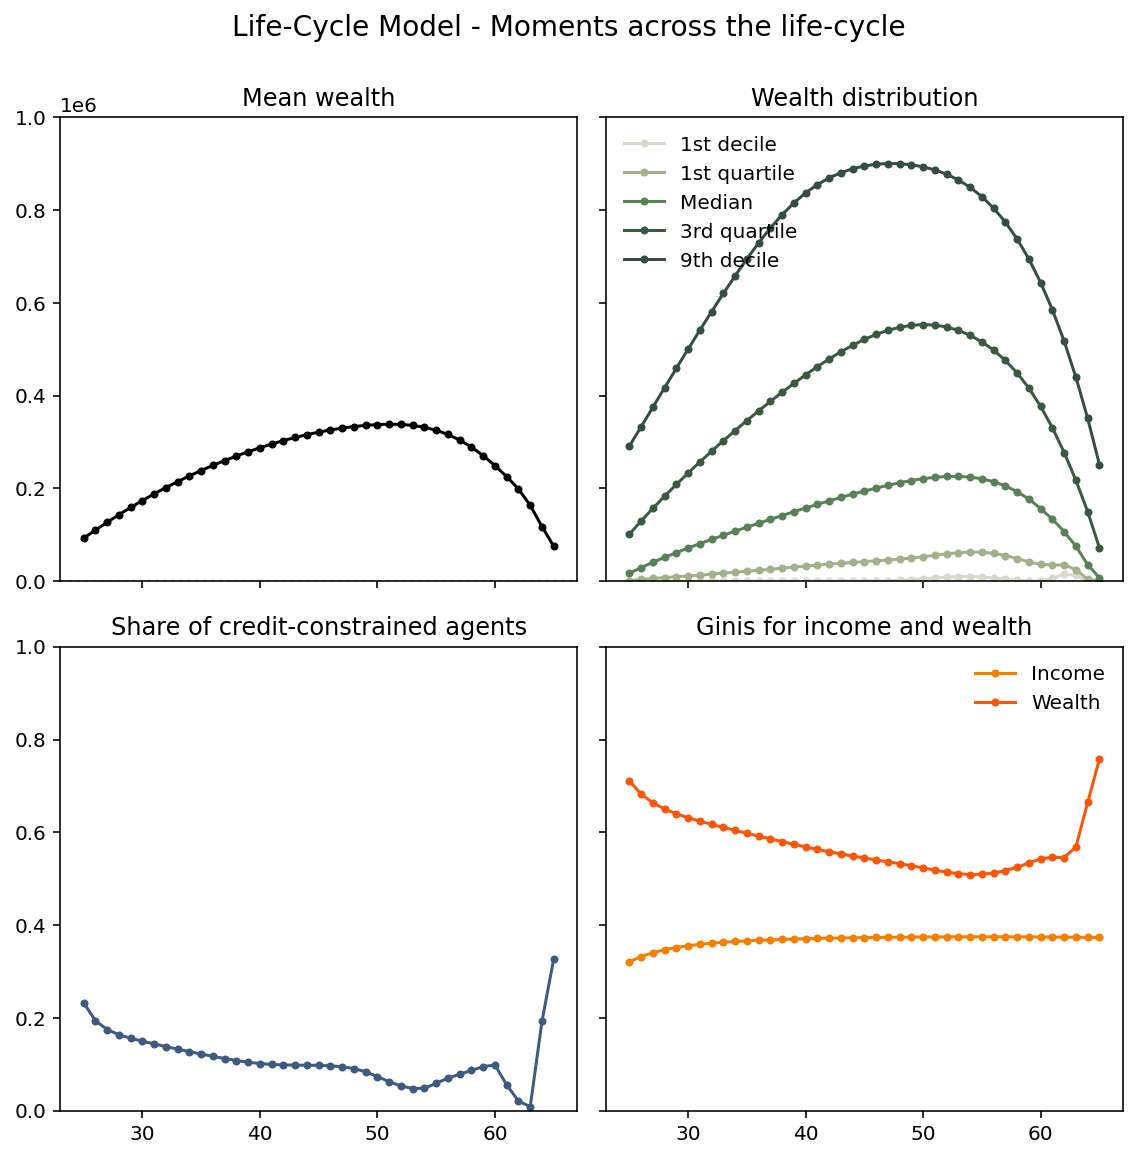

Saved to: life_cycle_moments.pdf


In [37]:
fig, ax = plt.subplots(2, 2, figsize=(8,8), sharex=True, sharey='row')
ax = ax.flatten()

ax[0].plot(t_fv, df_moments['wealth_mean'], 'k.-')
ax[0].axhline(0, ls=':', c='k', alpha=0.5)
ax[0].set_title('Mean wealth')

ax[1].plot(t_fv, df_moments['wealth_D1'], '#DAD7CD', marker='.', label='1st decile')
ax[1].plot(t_fv, df_moments['wealth_Q1'], '#A3B18A', marker='.', label='1st quartile')
ax[1].plot(t_fv, df_moments['wealth_median'], '#588157', marker='.', label='Median')
ax[1].plot(t_fv, df_moments['wealth_Q3'], '#3A5A40', marker='.', label='3rd quartile')
ax[1].plot(t_fv, df_moments['wealth_D9'], '#344E41', marker='.', label='9th decile')
ax[1].set_ylim([amin, amax])
ax[1].legend(frameon=False)
ax[1].set_title('Wealth distribution')

ax[2].plot(t_fv, df_moments['wealth_share_constrained'], '#3d5a80', marker='.')
ax[2].set_title('Share of credit-constrained agents')

ax[3].plot(t_fv, df_moments['gini_income'], '#f77f00', marker='.', label='Income')
ax[3].plot(t_fv, df_moments['gini_wealth'], '#fb5607', marker='.', label='Wealth')
ax[3].legend(frameon=False)
ax[3].set_title('Ginis for income and wealth')
ax[3].set_ylim([0,1])

plt.suptitle('Life-Cycle Model - Moments across the life-cycle', size=14, y=1)
plt.tight_layout()
savefig(fig, 'life_cycle_moments')